<a href="https://colab.research.google.com/github/anwishn/ESAA/blob/main/1003_%EA%B3%BC%EC%A0%9C_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽 가이드 p.132-145

## 06. 사이킷런으로 수행하는 타이타닉 생존자 예측



---



* 타이타닉 탑승자 데이터
>* Passengerid : 탑승자 데이터 일련번호
>* survived : 생존 여부, 0 = 사망, 1 = 생존
>* pclass : 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
>* sex : 탑승자 성별
>* name : 탑승자 이름
>* Age : 탑승자 나이
>* sibsp : 같이 탑승한 형제자매 또는 배우자 인원 수
>* parch : 같이 탑승한 부모님 또는 어린이 인원수
>* ticket : 티켓 번호
>* fare : 요금
>* cabin : 선실 번호
>* embarked : 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

1) 분석에 필요한 라이브러리 임포트

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('/content/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


2) 데이터 칼럼 타입 확인 - info()메서드

RangeIndex : DataFrame 인덱스의 범위, 전체 로우 수

판다스의 object 타입은 string 타입으로 봐도 무방 (<- 넘파이의 string 타입이 길이 제한이 있어 구분을 위해)

In [27]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


3) 결측치 처리 - fillna() 함수

Null 값을 평균 또는 고정 값으로 변경 - Age의 경우 평균 나이, 나머지 칼럼은 'N' 값으로 변경

모든 칼럼의 Null 값이 없는지 확인 isnull().sum().sum()

In [28]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


4) 남은 문자열 피처 값 분류 살펴보기

Cabin(선실) 값을 보면 속성값 제대로 정리x

선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳 중요 => 앞 문자만 추출

In [29]:
print(' Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

 Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [30]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


5) 데이터 탐색

* 성별이 생존 확률에 어떤 영향을 미쳤는지, 성별에 따른 생존자 수 비교

(아마도 여성과 아이들, 그리고 노약자가 제일 먼저 구조 대상, 다음으로 부자나 유명인)

Survived 칼럼은 레이블로서 결정 클래스 값/ 0=사망, 1=생존

In [31]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

=> 탑승객 - 남자 577명 > 여자 314명

여자 = 314명 중 233명 약 74.2% 생존 / 남자 = 577명 중 109명 18.8% 생존

* 시각화 - 시본 패키지 이용

기본적으로 맷플롯립에 기반, 좀 더 세련된 비주얼과 쉬운 API, 편리한 판다스 DataFrame과의 연동 등으로 데이터 분석을 위한 시각화로 애용되는 패키지

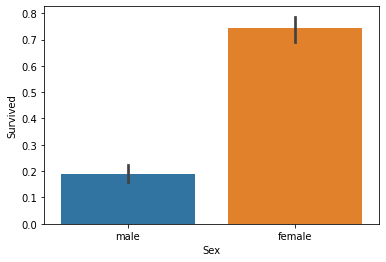

In [32]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

* 부자와 가난한 사람 간의 생존 확률 - 객실 등급별 성별에 따른 생존 확률

부를 측정할 수 있는 속성으로 객실 등급(일등실, 이등실, 삼등실)별로 생존 확률 보는 것보다 성별 함께 고려 분석

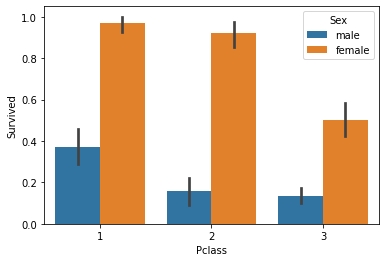

In [33]:
sns.barplot(x='Pclass',y='Survived',hue='Sex', data=titanic_df)

=> 여성의 경우 일, 이등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐

남성의 경우는 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높다

* Age에 따른 생존 확률

0-5세 = Baby, 6-12세 = Child, 13-18세 = Teenager, 19-25세 = Student, 26-35세 = Young Adult, 36-60세 = Adult, 61세 이상 = Elderly

-1 이하의 오류 값은 Unknown으로 분류

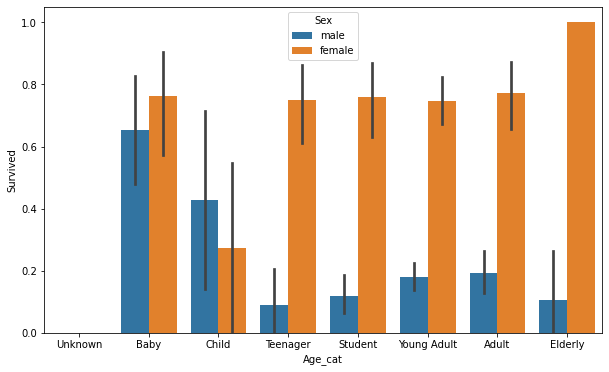

In [34]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용.
def get_category(age):
  cat=''
  if age<=-1: cat='Unknown'
  elif age<=5: cat='Baby'
  elif age<=12: cat='Child'
  elif age<=18: cat='Teenager'
  elif age<=25: cat='Student'
  elif age<=35: cat='Young Adult'
  elif age<=60: cat='Adult'
  else: cat='Elderly'

  return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat',y='Survived',hue='Sex',data=titanic_df, order=group_names)
titanic_df.drop('Age_cat',axis=1, inplace=True)

=> 여자 Baby의 경우 비교적 생존 확률이 높음. 여자 Child의 경우는 다른 연령대에 비해 생존 확률이 낮음. 여자 Elderly의 경우 매우 생존 확률이 높음

6) 남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환

* LabelEncoder 클래스를 이용해 레이블 인코딩 진행

LabelEncoder 객체 : 카테고리 값의 유형 수에 따라 0~(카테고리 유형 수-1)까지의 숫자 값으로 변환

* 대부분 인코딩 API는 fit(), transform()으로 데이터 변환

In [35]:
from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])

  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


=> Sex, Cabin, Embarked 속성이 숫자형으로 바뀜

7) 데이터의 전처리를 전체적으로 호출하는 함수 만들기 - Null 처리, 포매팅, 인코딩 수행하는 내부 함수로 구성

In [36]:
# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

1.  원본 데이터 다시 가공

원본 csv 파일 다시 로딩 후

>* 클래스 결정값 데이터 세트 = Survived 속성만 별도 분리해
>* 피처 데이터 세트 = Survived 속성을 드롭해

데이터 전처리 수행 함수 적용

In [37]:
# 원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

2. 별도의 테스트 데이터 세트 추출 - train_test_split()

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

3. ML 알고리즘인 결정 트리, 랜덤 포레스트, 로지스틱 회귀 이용해 학습/예측/평가

* 결정 트리 DecisionTreeClassifier
* 랜덤 포레스트 RandomForestClassifier
* 로지스틱 회귀 LogisticRegression

분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습(fit)하고 예측(predict), 평가(accuracy_score)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


=> 3개의 알고리즘 중 LogisticRegression이 타 알고리즘에 비해 높은 정확도 나타내

=> 아직 최적화 작업 수행x, 데이터 양 충분x -> 어떤 알고리즘이 가장 성능이 좋다고 평가할 수 없다 

4. 교차 검증으로 결정 트리 모델 평가 - 사이킷런 model_selection 패키지의 KFold 클래스, cross_val_score(), GridSearchCV 클래스

* KFold 클래스 이용 => 평균 정확도 약 78.23%

In [42]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
  # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
  kfold = KFold(n_splits=folds)
  scores=[]

  # KFold 교차 검증 수행.
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    # Classifier 학습, 예측, 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

  # 5개 fold에서의 평균 정확도 계산
  mean_score = np.mean(scores)
  print("평균 정확도: {0:.4f}".format(mean_score))

# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


* cross_val_score() API 이용 => 평균 정확도 약 78.79%

In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
  print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


=> cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할 -> K 폴드의 평균 정확도와 약간 다름

* GridSearchCV 이용 => 평균 정확도 87.15%

DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능 측정

In [44]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GirdSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GirdSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


=> 최적화된 하이퍼 파라미터인 max_depth = 2, min_samples_leaf = 1, min_samples_split = 2로 

DecisionTreeClassifier를 학습시킨 뒤 예측 정확도가 약 87.15%로 향상

=> 하이퍼 파라미터 변경 전보다 약 8% 이상 증가, 일반적으로 하이퍼 파라미터를 튜닝하더라도 이 정도 수준으로 증가하기는 매우 어렵다

## 07. 정리



---

**사이킷런** : 매우 많은 머신러닝 알고리즘 제공 + 쉽고 직관적인 API 프레임워크 + 편리하고 다양한 모듈 지원 

-> 파이썬 계열의 대표적인 머신러닝 패키지

* 머신러닝 애플리케이션 구성 방식
>* 1) 데이터의 가공 및 변환 과정의 **전처리 작업**
>* 2) 데이터를 학습 데이터와 테스트 데이터로 분리하는 **데이터 세트 분리 작업**
>* 3) 학습 데이터를 기반으로 머신러닝 알고리즘을 적용해 **모델 학습**
>* 4) 학습된 모델을 기반으로 테스트 데이터에 대한 **예측 수행**
>* 5) 예측된 결과값을 실제 결괏값과 비교해 머신러닝 모델에 대한 **평가 수행**

* 데이터의 전처리 작업 : 다양한 데이터 클렌징 작업(오류 데이터의 보정이나 결손값 처리 등), 인코딩 작업(레이블 인코딩이나 원-핫 인코딩), 데이터의 스케일링/정규화 작업 등으로 머신러닝 알고리즘이 최적으로 수행될 수 있게 데이터 사전 처리

* 학습 데이터 세트로 학습한 뒤 반드시 별도의 테스트 데이터 세트로 평가되어야해

* 테스트 데이터의 건수 부족이나 고정된 테스트 데이터 세트를 이용한 반복적인 모델의 학습과 평가 -> 해당 테스트 데이터 세트에만 치우친 빈약한 머신러닝 모델 만들 가능성 높음

* 해결 방안 => **교차 검증**

KFold, StratifiedKFold, cross_val_score() 등의 다양한 클래스와 함수 + GridSearchCV(최적의 하이퍼 파라미터 추출)